In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.models.forecasting.arima import ARIMA
from darts.utils.statistics import check_seasonality, extract_trend_and_seasonality, plot_acf

import numpy as np
import pandas as pd
from darts import TimeSeries
from darts.models import ExponentialSmoothing, NaiveSeasonal
from darts.utils.utils import ModelMode
# from darts.utils.likelihood_models import GaussianLikelihood
from darts.dataprocessing.transformers import Scaler


from statsmodels.tsa.seasonal import seasonal_decompose, STL , MSTL

import os
from pathlib import Path


pd.set_option('display.max_columns', 500)


## Data sampling

In [40]:
curr_folder_path = Path(os.path.abspath(""))
base_path = curr_folder_path.parent.absolute()
data_path = os.path.join(base_path, 'data')

df_customer = pd.read_csv(os.path.join(data_path, 'dim_customer.csv'))
df_product = pd.read_csv(os.path.join(data_path, 'dim_product.csv'))
df_region = pd.read_csv(os.path.join(data_path, 'dim_region.csv'))
df_salesorder = pd.read_csv(os.path.join(data_path, 'fct_salesorder.csv'))

df_ds1 = pd.read_csv(os.path.join(data_path, 'dim_datascience1__19_12h13.csv'))


In [41]:
df_ds1.sample(5)

,SALES_ORDER_ID,ACCOUNT_NUMBER,BILL_TO_ADDRESS_ID,CREDITCARD_ID,CUSTOMER_ID,CURRENCY_RATE_ID,DUE_DATE,FREIGHT,ONLINE_ORDER_FLAG,ORDER_DATE,SALES_PERSON_ID,SHIP_DATE,SHIP_TO_ADDRESS_ID,SHIP_METHOD_ID,SALES_STATUS,SUBTOTAL,TERRITORY_ID,TAXAMT,TOTAL_DUE,PRODUCT_ID,SALES_ORDER_DETAIL_ID,ORDER_QTY,SPECIAL_OFFER_ID,UNIT_PRICE,UNIT_PRICE_DISCOUNT,PRODUCT_CLASS,PRODUCT_COLOR,DAY_TO_MANUFACTURE,FINISHED_GOODS_FLAG,LIST_PRICE,PRODUCT_NAME,PRODUCT_LINE,PRODUCT_MODEL_ID,PRODUCT_NUMBER,PRODUCT_SUBCATEGORY_ID,SELL_END_DATE,SELL_START_DATE,PRODUCT_SIZE,SIZE_UNIT_MEASURE_CODE,STANDARD_COST,PRODUCT_STYLE,PRODUCT_WEIGHT,WEIGHT_UNIT_MEASURE_CODE,PERSON_ID,STORE_ID,BUSINESS_ENTITY_ID,STORE_NAME
92331,45780,10-4020-000442,517,1346.0,29734,3386.0,2012-03-12 00:00:00.000,938.1834,False,2012-02-29,282.0,2012-03-07,517,5,5,31193.3153,6,3002.1867,35133.6854,743,7623,2,1,714.7043,0.0,H,Black,1,True,1349.60,"HL Mountain Frame - Black, 42",M,5,FR-M94B-42,12,NaN,2011-05-31 00:00:00.000,42,CM,739.0410,U,2.72,LB,851,852.0,852.0,Original Bicycle Supply Company
15232,69761,10-4030-018068,27050,4757.0,18068,NaN,2014-04-14 00:00:00.000,60.9998,True,2014-04-02,NaN,2014-04-09,27050,1,5,2439.9900,4,195.1992,2696.1890,876,105510,1,1,120.0000,0.0,NaN,NaN,0,True,120.00,Hitch Rack - 4-Bike,S,118,RA-H123,26,NaN,2013-05-30 00:00:00.000,NaN,NaN,44.8800,NaN,NaN,NaN,17963,NaN,NaN,NaN
16859,43676,10-4020-000017,755,18153.0,29811,NaN,2011-06-12 00:00:00.000,426.0206,False,2011-05-31,275.0,2011-06-07,755,5,5,14203.4580,5,1363.2660,15992.7446,709,154,4,1,5.7000,0.0,NaN,White,0,True,9.50,"Mountain Bike Socks, M",M,18,SO-B909-M,23,2012-05-29 00:00:00.000,2011-05-31 00:00:00.000,M,NaN,3.3963,U,NaN,NaN,1017,1018.0,1018.0,Trusted Catalog Store
39012,64675,10-4030-017242,14369,1825.0,17242,10985.0,2014-02-01 00:00:00.000,20.2240,True,2014-01-20,NaN,2014-01-27,14369,1,5,808.9600,9,64.7168,893.9008,870,87262,1,1,4.9900,0.0,NaN,NaN,0,True,4.99,Water Bottle - 30 oz.,S,111,WB-H098,28,NaN,2013-05-30 00:00:00.000,NaN,NaN,1.8663,NaN,NaN,NaN,5334,NaN,NaN,NaN
69808,67346,10-4020-000451,882,19143.0,29737,NaN,2014-03-13 00:00:00.000,1250.0001,False,2014-03-01,284.0,2014-03-08,882,5,5,41375.1000,1,4000.0004,46625.1005,895,96984,2,1,200.0520,0.0,L,Blue,1,True,333.42,"LL Touring Frame - Blue, 50",T,10,FR-T67U-50,16,NaN,2013-05-30 00:00:00.000,50,CM,199.8519,U,3.10,LB,857,858.0,858.0,Roadway Bike Emporium


In [42]:
# df_customer.sample(5)

In [43]:
# df_product.sample(5)

In [44]:
# df_region.sample(5)

In [45]:
# df_salesorder.sample(5)

## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Data Science Task #1</p>

A fim de ajustar a distribuição de produtos e ter uma melhor estimativa sobre a necessidade de compra de matéria prima, faça uma previsão sobre a demanda dos próximos 3 meses de cada produto em cada loja. Além disso, aponte se há ou não a presença de sazonalidade em algum produto de sua escolha.

In order to adjust the distribution of products and have a better estimate the necessity of the purchase of raw materials, I'm planning on creating a model to forecast the demand for the next 3 months for each product in each store. In order to do so, which columns and from which schemas would be necessary to build such model? Be objective.

Cada loja: STORE_ID e STORE_NAME (customer)

Previsão temporal: Precisa de data. Usar SELL_END_DATE, SELL_START_DATE, ORDER_DATE (product)

De cada produto: PRODUCT_ID, PRODUCT_MODEL_ID, PRODUCT_NAME (product)

<Axes: xlabel='count', ylabel='Count'>

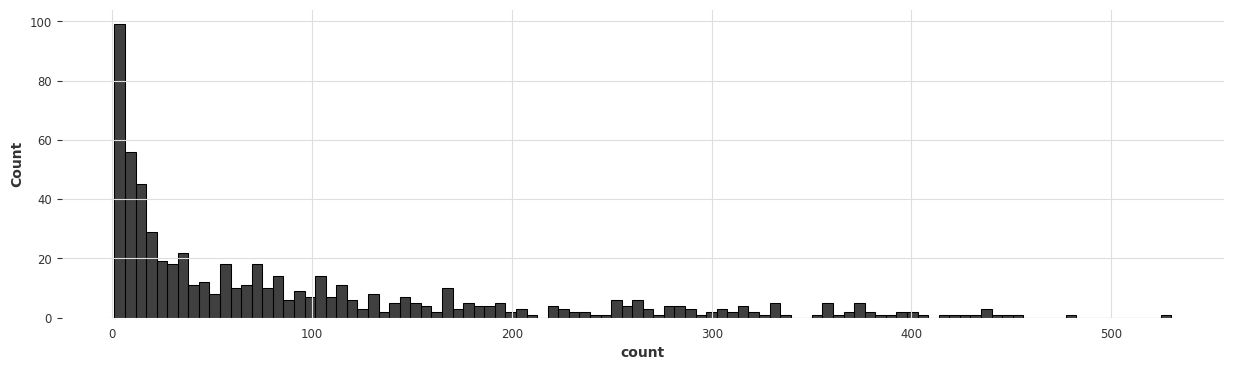

In [46]:
# Question: How many unique stores are there?
# df_ds1['STORE_NAME'].dropna().nunique() # Answer: 633

# Questions: How many sales each store did? Or, how is the distribution of sales accross stores?
fig, axes = plt.subplots(figsize=(15,4))
sns.histplot(df_ds1['STORE_NAME'].dropna().value_counts().to_frame(), x='count', bins=100, ax=axes)


266
266


<Axes: xlabel='count', ylabel='Count'>

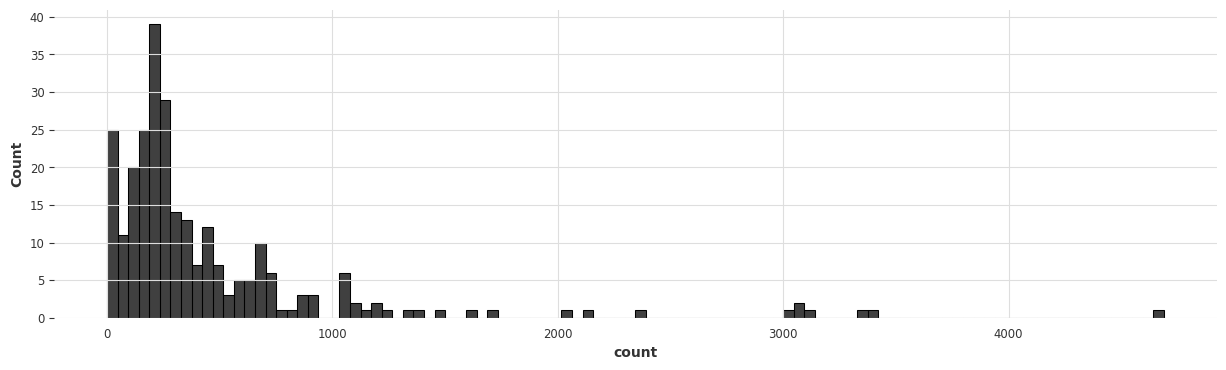

In [47]:
# Question: How many unique products are there?
print(df_ds1['PRODUCT_NAME'].dropna().nunique()) # Answer: 266
print(df_ds1['PRODUCT_ID'].dropna().nunique()) # Answer: 266


# Questions: How is the distribution of PRODUCT_NAME?
fig, axes = plt.subplots(figsize=(15,4))
sns.histplot(df_ds1['PRODUCT_NAME'].dropna().value_counts().to_frame(), x='count', bins=100, ax=axes)

### Approach 1: Creating Product forecasts, regardless of store

Since we are creating a single model for each product, we have a univariate relationship. Besides, since there are cases where we have few samples of data, it wouldn't be wise to apply a complex model in all modeling cases. Last but not least, it is always a good idea to start simple, not only because it is easier, but because it can also create a baseline for future comparisons and generate insights as the modeling stage improves.

Thus, we will use the ARIMA model, which is a univariate time series model that accepts only exogenous variables in order to make it's predictions.


In [48]:
df_ds1['PRODUCT_NAME'].dropna().value_counts().to_frame().T

PRODUCT_NAME,Water Bottle - 30 oz.,AWC Logo Cap,Patch Kit/8 Patches,Mountain Tire Tube,"Sport-100 Helmet, Blue","Sport-100 Helmet, Red","Sport-100 Helmet, Black",Road Tire Tube,Fender Set - Mountain,Mountain Bottle Cage,Road Bottle Cage,"Long-Sleeve Logo Jersey, L",Touring Tire Tube,HL Mountain Tire,Bike Wash - Dissolver,"Mountain-200 Black, 38","Long-Sleeve Logo Jersey, M","Mountain-200 Black, 42",ML Mountain Tire,"Mountain-200 Silver, 38","Half-Finger Gloves, M","Long-Sleeve Logo Jersey, XL",Hydration Pack - 70 oz.,"Mountain-200 Black, 46","Mountain-200 Silver, 46",LL Road Tire,"Mountain-200 Silver, 42",Touring Tire,ML Road Tire,"Short-Sleeve Classic Jersey, XL","Half-Finger Gloves, S",LL Mountain Tire,HL Road Tire,"Short-Sleeve Classic Jersey, L",Hitch Rack - 4-Bike,"Road-550-W Yellow, 38","Road-550-W Yellow, 48","Short-Sleeve Classic Jersey, S","Road-250 Black, 48","Women's Mountain Shorts, L","Road-250 Black, 44","Road-650 Black, 52","Road-750 Black, 52","Road-650 Red, 44","Road-550-W Yellow, 40","Road-750 Black, 48","Classic Vest, S","Women's Mountain Shorts, M","Road-650 Red, 60","Half-Finger Gloves, L","Road-250 Black, 52","Road-650 Red, 48","Road-550-W Yellow, 42","Women's Mountain Shorts, S","Road-650 Black, 58","Road-650 Red, 62","Racing Socks, L","LL Road Frame - Black, 52","Racing Socks, M","Road-350-W Yellow, 40","Road-350-W Yellow, 48","Classic Vest, M","Road-750 Black, 58","Road-250 Red, 58",ML Mountain Handlebars,"Road-550-W Yellow, 44","HL Mountain Frame - Silver, 38","ML Road Frame-W - Yellow, 44","Road-250 Black, 58","HL Mountain Frame - Black, 42","Road-150 Red, 56","Road-150 Red, 62","Road-750 Black, 44","Road-650 Black, 60","Road-350-W Yellow, 42","Touring-1000 Blue, 46","Road-650 Black, 44","Women's Tights, L","Road-650 Red, 52","Touring-1000 Yellow, 46","Touring-1000 Blue, 60","Touring-1000 Yellow, 60","Long-Sleeve Logo Jersey, S","Women's Tights, S","Road-150 Red, 48","Short-Sleeve Classic Jersey, M","LL Road Frame - Black, 58","Touring-2000 Blue, 54","Road-150 Red, 52","Road-250 Red, 48","LL Road Frame - Red, 60","LL Road Frame - Red, 44","Road-250 Red, 44","Full-Finger Gloves, L","Full-Finger Gloves, M","Road-150 Red, 44","ML Road Frame-W - Yellow, 38","Men's Bib-Shorts, M","ML Road Frame-W - Yellow, 48","Touring-2000 Blue, 60","Touring-1000 Yellow, 50","Touring-1000 Blue, 50","Road-350-W Yellow, 44","Touring-3000 Yellow, 62","Touring-3000 Yellow, 44","Road-250 Red, 52",LL Road Pedal,"Touring-3000 Blue, 50",LL Road Rear Wheel,LL Mountain Handlebars,"Mountain-400-W Silver, 40","Road-650 Black, 48","Road-650 Black, 62","HL Mountain Frame - Black, 38","LL Road Frame - Red, 48","HL Mountain Frame - Silver, 46","LL Road Frame - Red, 62","Touring-2000 Blue, 46","Men's Sports Shorts, M","Road-650 Red, 58","Touring-3000 Blue, 54","Touring-3000 Yellow, 50","Touring-1000 Blue, 54","Touring-1000 Yellow, 54",HL Road Handlebars,"Road-450 Red, 52",Minipump,Front Brakes,ML Mountain Rear Wheel,ML Road Pedal,HL Road Pedal,Cable Lock,HL Mountain Rear Wheel,Front Derailleur,"ML Mountain Frame - Black, 48",HL Mountain Pedal,"ML Mountain Frame-W - Silver, 40","Mountain-400-W Silver, 38",Chain,All-Purpose Bike Stand,"Mountain-100 Black, 48","Mountain-100 Black, 44","Mountain-100 Silver, 38","Full-Finger Gloves, S","Mountain-400-W Silver, 46","Touring-3000 Blue, 58","Mountain-500 Silver, 52","Mountain-100 Black, 38","Mountain-100 Silver, 44",LL Mountain Front Wheel,"Mountain-500 Black, 48","Men's Bib-Shorts, S","Mountain-400-W Silver, 42","ML Mountain Frame-W - Silver, 42","Mountain-300 Black, 44","Mountain-100 Black, 42","Mountain-500 Silver, 48","Touring-3000 Yellow, 54","LL Mountain Frame - Black, 44","Road-450 Red, 58","ML Mountain Frame - Black, 38","LL Mountain Frame - Silver, 42","Mountain-300 Black, 40","Mountain-300 Black, 48",HL Mountain Seat/Saddle,"Mountain-500 Silver, 42","Mountain-500 Silver, 40","Mountain-100 Silver, 42","Mountain-300 Black, 38","HL Road Frame - Red, 44",HL Crankset,"HL Road Frame - Red, 62

In [ ]:
df = df_ds1[['PRODUCT_NAME', 'PRODUCT_ID', 'ORDER_QTY', 'ORDER_DATE', 'STORE_NAME', 'STORE_ID']]
df



,PRODUCT_NAME,PRODUCT_ID,ORDER_QTY,ORDER_DATE,STORE_NAME,STORE_ID
0,"Road-750 Black, 52",999,1,2014-04-28,NaN,NaN
1,"Half-Finger Gloves, S",858,7,2012-05-30,Original Bicycle Supply Company,852.0
2,"Long-Sleeve Logo Jersey, L",715,1,2013-11-30,NaN,NaN
3,"LL Mountain Frame - Black, 44",925,2,2014-01-29,Closest Bicycle Store,1260.0
4,"Half-Finger Gloves, L",860,1,2014-01-02,NaN,NaN
...,...,...,...,...,...,...
121312,"LL Road Frame - Red, 60",729,1,2012-03-30,Active Transport Inc.,1936.0
121313,"Touring-3000 Yellow, 50",962,1,2013-12-31,Fitness Department Stores,1814.0
121314,"Mountain-400-W Silver, 42",982,1,2014-05-23,NaN,NaN
121315,"LL Mountain Frame - Silver, 42",917,3,2013-08-30,Great Bikes,318.0


In [66]:
# AGGREGATED TIMESERIES:
# Objective: df is a dataframe with PRODUCT_NAME, PRODUCT_ID, ORDER_QTY, ORDER_DATE, STORE_NAME and STORE_ID. The time related column is ORDER_DATE, and the numerical quantity is ORDER_QTY. I want to create a pandas dataframe that contains multiple timeseries (one for each PRODUCT_ID).

# Step 1: Create the time series

# Step 1.1: Get start and end dates
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])
start_date = df['ORDER_DATE'].min()
end_date = df['ORDER_DATE'].max()

# Step 1.2: Create date_range
dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Step 2: Create a DataFrame with the full date range for each PRODUCT_ID
product_ids = df['PRODUCT_ID'].unique()

# Create a DataFrame with all combinations of PRODUCT_ID and dates
full_index = pd.MultiIndex.from_product([product_ids, dates], names=["PRODUCT_ID", "ORDER_DATE"])
full_df = pd.DataFrame(index=full_index).reset_index()

# Step 3: Merge with the original dataframe
# Aggregate ORDER_QTY by PRODUCT_ID and ORDER_DATE
agg_df = (
    df.groupby(['PRODUCT_ID', 'ORDER_DATE'])['ORDER_QTY']
    .sum()
    .reset_index()
)

# Merge to align with the full date range
result = pd.merge(full_df, agg_df, on=["PRODUCT_ID", "ORDER_DATE"], how="left")

# Step 4: Fill missing values with 0 (or another strategy)
result['ORDER_QTY'] = result['ORDER_QTY'].fillna(0)

# Final result: DataFrame with one time series per PRODUCT_ID
result

/tmp/ipykernel_22800/1813608271.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])


,PRODUCT_ID,ORDER_DATE,ORDER_QTY
0,999,2011-05-31,0.0
1,999,2011-06-01,0.0
2,999,2011-06-02,0.0
3,999,2011-06-03,0.0
4,999,2011-06-04,0.0
...,...,...,...
299777,942,2014-06-26,0.0
299778,942,2014-06-27,0.0
299779,942,2014-06-28,0.0
299780,942,2014-06-29,0.0


In [68]:

# Step 1: Prepare the ORDER_DATE column
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])

# Step 1.1: Get start and end dates
start_date = df['ORDER_DATE'].min()
end_date = df['ORDER_DATE'].max()

# Step 1.2: Create a date_range
dates = pd.date_range(start=start_date, end=end_date, freq="D")

# Step 2: Create a DataFrame with the full date range for all PRODUCT_IDs
product_ids = df['PRODUCT_ID'].unique()

# Create a DataFrame with all combinations of PRODUCT_ID and dates
full_index = pd.MultiIndex.from_product([product_ids, dates], names=["PRODUCT_ID", "ORDER_DATE"])
full_df = pd.DataFrame(index=full_index).reset_index()

# Step 3: Merge with the original dataframe
# Aggregate ORDER_QTY by PRODUCT_ID and ORDER_DATE
agg_df = (
    df.groupby(['PRODUCT_ID', 'ORDER_DATE'])['ORDER_QTY']
    .sum()
    .reset_index()
)

# Merge to align with the full date range
result = pd.merge(full_df, agg_df, on=["PRODUCT_ID", "ORDER_DATE"], how="left")

# Step 4: Pivot the table to have PRODUCT_IDs as columns
pivoted = result.pivot(index="ORDER_DATE", columns="PRODUCT_ID", values="ORDER_QTY")

# Step 5: Fill missing values with 0
pivoted = pivoted.fillna(0).astype(int)

# Display the result
pivoted

/tmp/ipykernel_22800/2395413073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])


PRODUCT_ID,707,708,709,710,711,712,713,714,715,716,717,718,719,722,723,725,726,727,729,730,732,733,736,738,739,741,742,743,744,745,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,784,785,786,787,788,789,790,791,792,793,794,795,796,797,798,799,800,801,802,804,805,806,807,808,809,810,811,813,814,815,816,817,819,820,822,823,824,825,826,827,828,830,831,832,833,835,836,838,839,841,843,844,849,850,852,853,854,855,856,857,858,859,860,861,862,863,864,865,866,867,868,869,870,871,872,873,874,875,876,877,878,879,880,881,882,883,884,885,886,887,888,889,890,891,892,893,894,895,896,897,898,899,900,902,903,904,905,906,907,908,909,910,911,913,914,915,916,917,918,919,920,921,922,923,924,925,926,927,928,929,930,931,932,933,934,935,936,937,938,939,940,941,942,943,944,945,946,947,948,949,950,951,952,953,954,955,956,957,958,959,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,996,997,998,999
ORDER_DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-05-31,24,27,38,5,33,40,0,16,49,19,0,0,0,8,0,15,9,0,16,14,16,4,0,19,0,2,3,1,0,1,4,2,4,0,0,0,14,27,11,14,0,46,0,43,19,44,20,14,30,11,1,13,0,29,10,5,17,7,22,16,23,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-06-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-06-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-06-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2011-06-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [76]:
df[df['PRODUCT_ID'] == 707].sort_values(by='ORDER_DATE')

,PRODUCT_NAME,PRODUCT_ID,ORDER_QTY,ORDER_DATE,STORE_NAME,STORE_ID
53458,"Sport-100 Helmet, Red",707,2,2011-05-31,Retail Mall,592.0
63622,"Sport-100 Helmet, Red",707,1,2011-05-31,Juvenile Sports Equipment,440.0
38361,"Sport-100 Helmet, Red",707,2,2011-05-31,Clamps & Brackets Co.,306.0
99976,"Sport-100 Helmet, Red",707,4,2011-05-31,Area Bike Accessories,302.0
47396,"Sport-100 Helmet, Red",707,1,2011-05-31,Latest Sports Equipment,518.0
...,...,...,...,...,...,...
85428,"Sport-100 Helmet, Red",707,1,2014-06-27,NaN,NaN
81978,"Sport-100 Helmet, Red",707,1,2014-06-28,NaN,NaN
25097,"Sport-100 Helmet, Red",707,1,2014-06-30,NaN,NaN
80113,"Sport-100 Helmet, Red",707,1,2014-06-30,NaN,NaN


In [ ]:
# Step 1: Create the time series


# products = ['Water Bottle - 30 oz.', 'Touring-1000 Blue, 60', 'LL Mountain Frame - Silver, 52']
products = df_ds1['PRODUCT_NAME'].unique()

dict_have_seasonality = {}
dict_donthave_seasonality = {}
dict_error = {}


for product in products:
    _df = df_ds1[df_ds1['PRODUCT_NAME'] == product][['ORDER_DATE', 'ORDER_QTY']]
    _df['ORDER_DATE'] = pd.to_datetime(_df['ORDER_DATE'])
    _df = _df.set_index('ORDER_DATE').sort_index()
    _df = _df.groupby('ORDER_DATE').sum()
    _df = _df.asfreq('D')
    sample_size = _df.shape[0]

    try:
        _ts = TimeSeries.from_dataframe(df=_df, fill_missing_dates=True, freq=None)
        # Imputation
        # _ts = fill_missing_values(_ts, fill=float(0))
        _ts = fill_missing_values(_ts)

        is_seasonal, period = check_seasonality(_ts, max_lag=50)
        if is_seasonal:
            dict_have_seasonality[product] = sample_size
        else:
            dict_donthave_seasonality[product] = sample_size
    except:
        dict_error[product] = sample_size

    print(f"-----------------------------------\n{product}")
    print(f"Number of original samples: {sample_size}")
    if is_seasonal:
        print(f"Seasonality detected: Period {period}.")
        # print(f"{product} appears to be seasonal with period {period}.")
    else:
        # print(f"There wasn't detected any seasonality in {product}.")
        print(f"Seasonality not detected.")



# _ts.plot()

ValueError: Input time series must be of (length>=3) when fill_missing_dates=True and freq=None.


In [59]:
# product = 'LL Mountain Frame - Black, 44'
product = 'Road-750 Black, 52'

_df = df_ds1[df_ds1['PRODUCT_NAME'] == product][['ORDER_DATE', 'ORDER_QTY']]
_df['ORDER_DATE'] = pd.to_datetime(_df['ORDER_DATE'])
_df = _df.set_index('ORDER_DATE').sort_index()
_df = _df.groupby('ORDER_DATE').sum()
_df = _df.asfreq('D')
sample_size = _df.shape[0]

_ts = TimeSeries.from_dataframe(df=_df, fill_missing_dates=True, freq=None)
# Imputation
# _ts = fill_missing_values(_ts, fill=float(0))
_ts = fill_missing_values(_ts, method='polynomial', order=1)

is_seasonal, period = check_seasonality(_ts, max_lag=50)
if is_seasonal:
    dict_have_seasonality[product] = sample_size
else:
    dict_donthave_seasonality[product] = sample_size


print(f"-----------------------------------\n{product}")
print(f"Number of original samples: {sample_size}")
if is_seasonal:
    print(f"Seasonality detected: Period {period}.")
    # print(f"{product} appears to be seasonal with period {period}.")
else:
    # print(f"There wasn't detected any seasonality in {product}.")
    print(f"Seasonality not detected.")



_ts.plot()

NameError: name 'dict_have_seasonality' is not defined

In [140]:
# len(dict_donthave_seasonality)
# dict_donthave_seasonality

# len(dict_have_seasonality)
# dict_have_seasonality

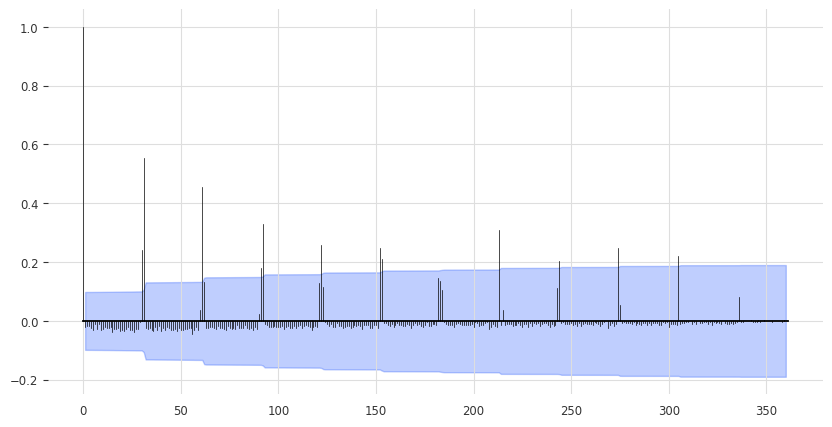

In [95]:
# plot_acf(some_ts, m=30, max_lag=360)
plot_acf(some_ts, max_lag=360, alpha=0.05)


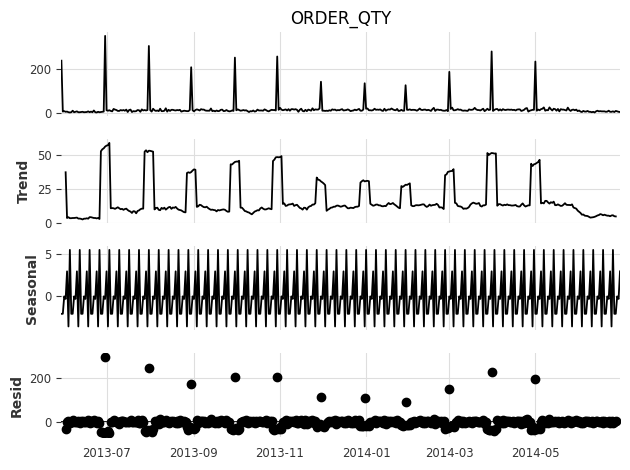

In [80]:
foo = seasonal_decompose(some_ts.pd_series())
foo.plot();

# dir(some_ts)


In [ ]:
trend, seasonal = extract_trend_and_seasonality(some_ts)

(<TimeSeries (DataArray) (ORDER_DATE: 397, component: 1, sample: 1)> Size: 3kB
 array([[[30.28571429]],
 
        [[26.66326531]],
 
        [[23.04081633]],
 
        [[37.28571429]],
 
        [[ 3.71428571]],
 
        [[ 4.28571429]],
 
        [[ 3.57142857]],
 
        [[ 3.57142857]],
 
        [[ 3.71428571]],
 
        [[ 3.71428571]],
 
 ...
 
        [[ 5.42857143]],
 
        [[ 5.42857143]],
 
        [[ 5.        ]],
 
        [[ 5.57142857]],
 
        [[ 5.71428571]],
 
        [[ 5.        ]],
 
        [[ 4.85714286]],
 
        [[ 5.15306122]],
 
        [[ 5.10204082]],
 
        [[ 5.05102041]]])
 Coordinates:
   * ORDER_DATE  (ORDER_DATE) datetime64[ns] 3kB 2013-05-30 ... 2014-06-30
   * component   (component) <U1 4B '0'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 <TimeSeries (DataArray) (ORDER_DATE: 397, component: 1, sample: 1)> Size: 3kB
 array([[[1.02048828]],
 
        [[0.97730322]],
 
 

### Approach 2: Creating Product forecasts per store

### Approach 3: Hierarchical forecasting

/tmp/ipykernel_22800/1033001279.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start="2023-01-01", periods=n_months, freq="M")


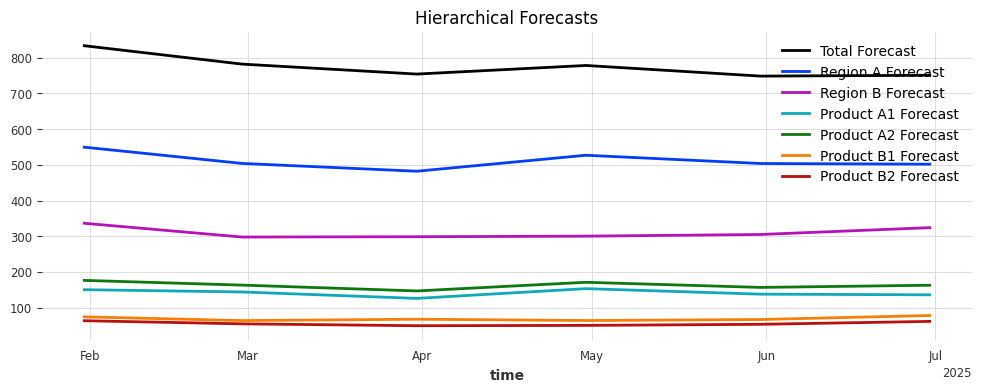

In [3]:

# Step 1: Generate synthetic hierarchical data
np.random.seed(42)
n_months = 24
dates = pd.date_range(start="2023-01-01", periods=n_months, freq="M")

# Total sales (top-level)
total_sales = 1000 + np.random.normal(0, 50, n_months).cumsum()

# Regional sales (middle-level)
region_a_sales = 0.6 * total_sales + np.random.normal(0, 20, n_months)
region_b_sales = 0.4 * total_sales + np.random.normal(0, 20, n_months)

# Product category sales (bottom-level)
product_a1_sales = 0.5 * region_a_sales + np.random.normal(0, 10, n_months)
product_a2_sales = 0.5 * region_a_sales + np.random.normal(0, 10, n_months)
product_b1_sales = 0.6 * region_b_sales + np.random.normal(0, 10, n_months)
product_b2_sales = 0.4 * region_b_sales + np.random.normal(0, 10, n_months)

# Step 2: Create TimeSeries objects for each level
total_series = TimeSeries.from_times_and_values(dates, total_sales)
region_a_series = TimeSeries.from_times_and_values(dates, region_a_sales)
region_b_series = TimeSeries.from_times_and_values(dates, region_b_sales)
product_a1_series = TimeSeries.from_times_and_values(dates, product_a1_sales)
product_a2_series = TimeSeries.from_times_and_values(dates, product_a2_sales)
product_b1_series = TimeSeries.from_times_and_values(dates, product_b1_sales)
product_b2_series = TimeSeries.from_times_and_values(dates, product_b2_sales)

# Step 3: Forecast each series
def forecast_series(series, forecast_horizon, model):
    model.fit(series)
    return model.predict(forecast_horizon)

forecast_horizon = 6

# Top-level forecast
model_total = ExponentialSmoothing()
total_forecast = forecast_series(total_series, forecast_horizon, model_total)

# Regional forecasts
model_region = ExponentialSmoothing()
region_a_forecast = forecast_series(region_a_series, forecast_horizon, model_region)
region_b_forecast = forecast_series(region_b_series, forecast_horizon, model_region)

# Bottom-level forecasts
model_product = ExponentialSmoothing()
product_a1_forecast = forecast_series(product_a1_series, forecast_horizon, model_product)
product_a2_forecast = forecast_series(product_a2_series, forecast_horizon, model_product)
product_b1_forecast = forecast_series(product_b1_series, forecast_horizon, model_product)
product_b2_forecast = forecast_series(product_b2_series, forecast_horizon, model_product)

# Step 4: Reconcile forecasts (top-down approach)
# Ensure bottom-level forecasts sum up to top-level forecast
region_total_forecast = region_a_forecast + region_b_forecast
scaling_factor_region_a = region_a_forecast / region_total_forecast
scaling_factor_region_b = region_b_forecast / region_total_forecast

product_a1_forecast = product_a1_forecast * scaling_factor_region_a
product_a2_forecast = product_a2_forecast * scaling_factor_region_a
product_b1_forecast = product_b1_forecast * scaling_factor_region_b
product_b2_forecast = product_b2_forecast * scaling_factor_region_b

# Step 5: Visualize the forecasts
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
total_forecast.plot(label="Total Forecast")
region_a_forecast.plot(label="Region A Forecast")
region_b_forecast.plot(label="Region B Forecast")
product_a1_forecast.plot(label="Product A1 Forecast")
product_a2_forecast.plot(label="Product A2 Forecast")
product_b1_forecast.plot(label="Product B1 Forecast")
product_b2_forecast.plot(label="Product B2 Forecast")
plt.title("Hierarchical Forecasts")
plt.legend()
plt.show()


## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Data Science Task #2</p>

Seria possível resolver este problema através de uma abordagem utilizando modelos de regressão? Se sim, qual demonstra melhor resultado? Justifique utilizando métricas de avaliação.



## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Data Science Task #3</p>

Os novos centros de distribuição passaram a ser divididos em províncias nos EUA e em países no resto do mundo. Qual desses grupos apresentou mais crescimento em demanda nos três meses previstos no item 8?


Provincia x País: STATEPROVINCE_NAME, IS_PROVINCE_FLAG. Talvez COUNTRY_REGION_NAME (region)

Centro de distribuição: ???

Crescimento em demanda: ???

## <p style="background-color:#56BBD1;font-family:newtimeroman;color:#2E3035;font-size:150%;text-align:center;border-radius:10px 10px;">Data Science Task #4</p>

Um novo fornecedor de luvas, que agora engloba toda a produção mundial, precisa ter uma estimativa de quantos zíperes precisa pedir para os próximos 3 meses. Levando em consideração que são necessários 2 zíperes por par, quantos seriam necessários?


In [5]:
from darts.datasets import AustralianTourismDataset

tourism_series = AustralianTourismDataset().load()

<Axes: xlabel='time'>

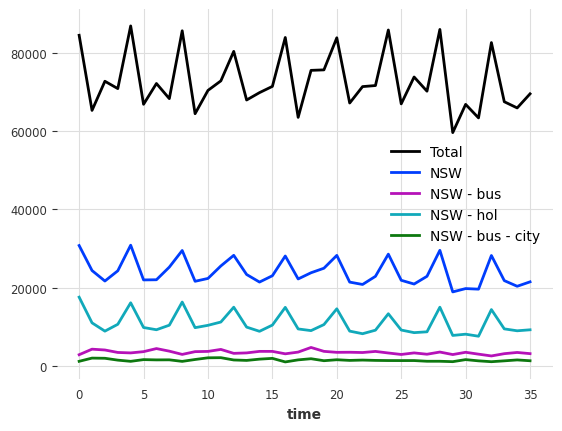

In [6]:
tourism_series[["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]].plot()

<Axes: xlabel='time'>

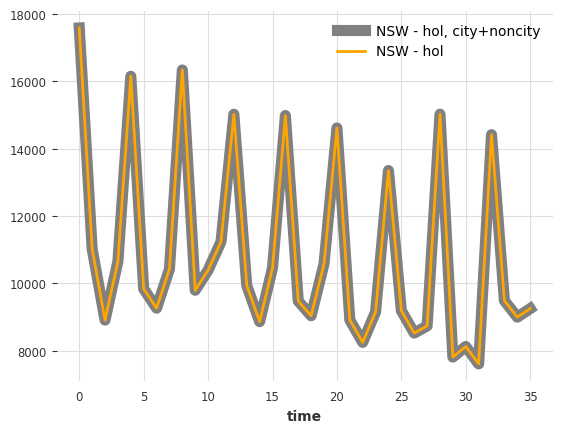

In [7]:
sum_city_noncity = (
    tourism_series["NSW - hol - city"] + tourism_series["NSW - hol - noncity"]
)
sum_city_noncity.plot(label="NSW - hol, city+noncity", lw=8, color="grey")
tourism_series["NSW - hol"].plot(color="orange")

<Axes: xlabel='time'>

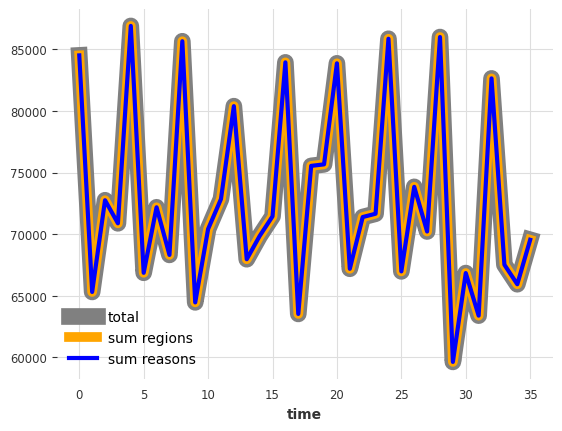

In [8]:
reasons = ["Hol", "VFR", "Bus", "Oth"]
regions = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT"]
city_labels = ["city", "noncity"]

tourism_series["Total"].plot(label="total", lw=12, color="grey")
sum([tourism_series[region] for region in regions]).plot(
    label="sum regions", lw=7, color="orange"
)
sum([tourism_series[reason] for reason in reasons]).plot(
    label="sum reasons", lw=3, color="blue"
)

In [12]:
from itertools import product

hierarchy = dict()

# Fill in grouping by reason
for reason in reasons:
    hierarchy[reason] = ["Total"]

# Fill in grouping by region
for region in regions:
    hierarchy[region] = ["Total"]

# Fill in grouping by (region, reason)
for region, reason in product(regions, reasons):
    hierarchy["{} - {}".format(region, reason.lower())] = [reason, region]

# Fill in grouping by (region, reason, <city>)
for region, reason, city in product(regions, reasons, city_labels):
    hierarchy["{} - {} - {}".format(region, reason.lower(), city)] = [
        "{} - {}".format(region, reason.lower())
    ]

In [13]:
for component in ["Hol", "NSW - hol", "NSW - bus - city"]:
    print(f"{component} -> {hierarchy[component]}")

Hol -> ['Total']
NSW - hol -> ['Hol', 'NSW']
NSW - bus - city -> ['NSW - bus']


In [14]:
tourism_series = tourism_series.with_hierarchy(hierarchy)

In [15]:
train, val = tourism_series[:-12], tourism_series[-12:]

In [17]:
from darts.models.forecasting.linear_regression_model import LinearRegressionModel

model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

<Axes: xlabel='time'>

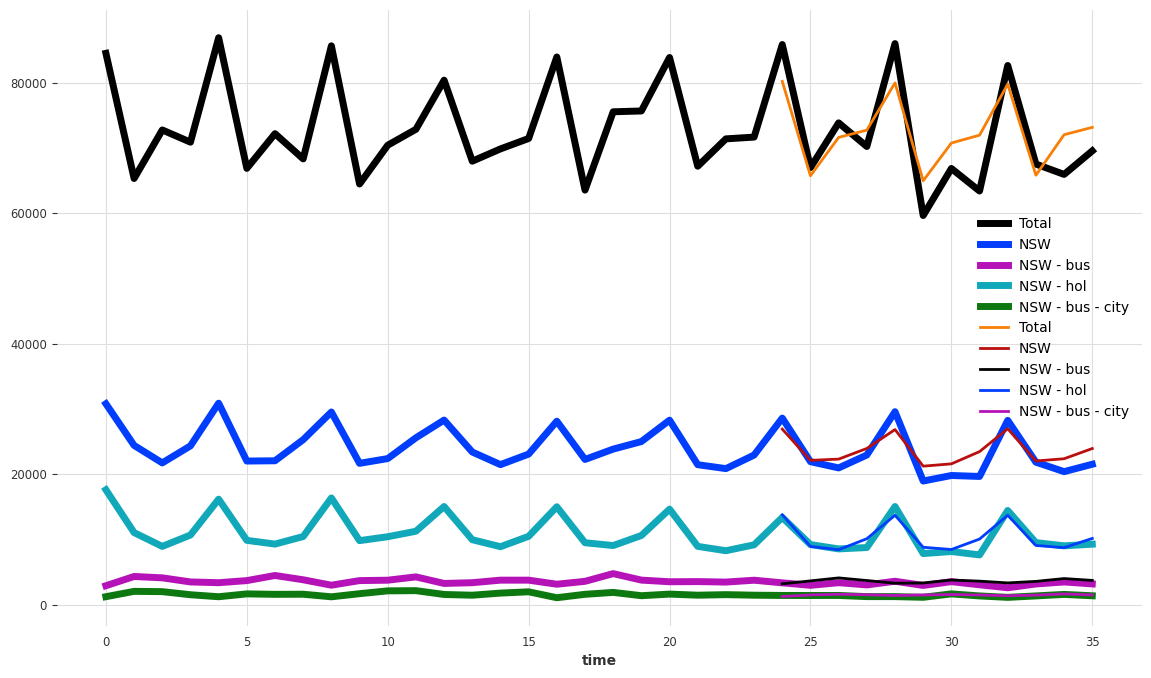

In [18]:
components_to_show = ["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]
plt.figure(figsize=(14, 8))
tourism_series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=2)

In [30]:
# from sklearn.metrics import mean_absolute_error as mae
from darts.metrics.metrics import mae

# we pre-generate some of the components' names
regions_reasons_comps = list(
    map(lambda t: "{} - {}".format(t[0], t[1].lower()), product(regions, reasons))
)

regions_reasons_city_comps = list(
    map(
        lambda t: "{} - {} - {}".format(t[0], t[1].lower(), t[2]),
        product(regions, reasons, city_labels),
    )
)


def measure_mae(pred):
    def print_mae_on_subset(subset, name):
        _m = mae(
            [pred[c] for c in subset],
            [val[c] for c in subset]
            # inter_reduction=np.mean,
        )
        print(f"mean MAE on {name}: {np.mean(_m)}")

    print_mae_on_subset(["Total"], "total")
    print_mae_on_subset(reasons, "reasons")
    print_mae_on_subset(regions, "regions")
    print_mae_on_subset(regions_reasons_comps, "(region, reason)")
    print_mae_on_subset(regions_reasons_city_comps, "(region, reason, city)")


measure_mae(pred)

mean MAE on total: 4142.619881338443
mean MAE on reasons: 1284.7904706686463
mean MAE on regions: 805.1957320345209
mean MAE on (region, reason): 313.04039479051505
mean MAE on (region, reason, city): 190.67660721304398


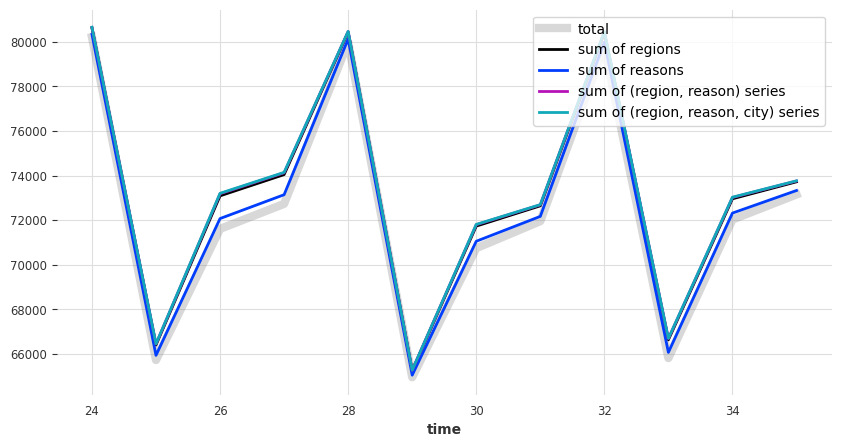

In [34]:
def plot_forecast_sums(pred_series):
    plt.figure(figsize=(10, 5))

    pred_series["Total"].plot(label="total", lw=6, alpha=0.3, color="grey")
    sum([pred_series[r] for r in regions]).plot(label="sum of regions")
    sum([pred_series[r] for r in reasons]).plot(label="sum of reasons")
    sum([pred_series[t] for t in regions_reasons_comps]).plot(
        label="sum of (region, reason) series"
    )
    sum([pred_series[t] for t in regions_reasons_city_comps]).plot(
        label="sum of (region, reason, city) series"
    )

    legend = plt.legend(loc="best", frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")


plot_forecast_sums(pred)

In [35]:
from darts.dataprocessing.transformers.reconciliation import MinTReconciliator

reconciliator = MinTReconciliator(method="wls_val")
reconciliator.fit(train)
reconcilied_preds = reconciliator.transform(pred)

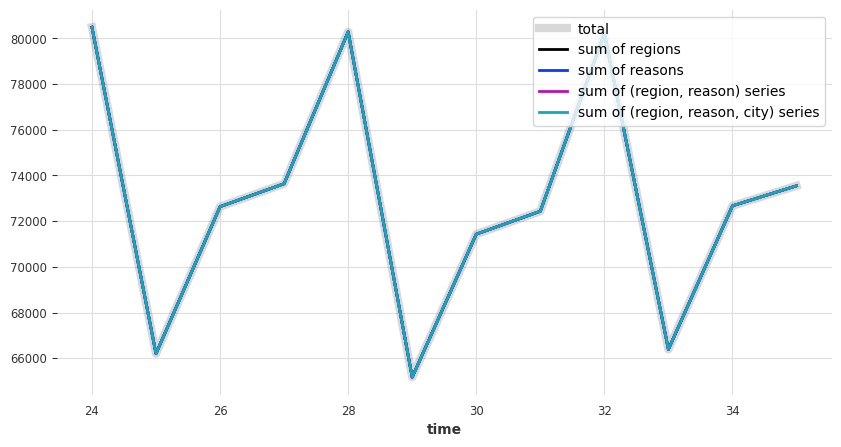

In [36]:
plot_forecast_sums(reconcilied_preds)

In [37]:
measure_mae(reconcilied_preds)

mean MAE on total: 4161.053141954356
mean MAE on reasons: 1294.3539640760744
mean MAE on regions: 789.9824426848385
mean MAE on (region, reason): 309.62619575307923
mean MAE on (region, reason, city): 189.79811678878713
